# Sherrington-Kirkpatrick Model

The cost function of the SK model is
$$
\hat H_P = \frac{1}{\sqrt{N}}\sum_{i<j\leq N} J_{ij} \hat{Z}_i \hat{Z}_j,
$$
where the couplings $J_{ij}$ are i.i.d. standard Gaussian variables, i.e. with zero mean $\left\langle J_{ij} \right\rangle = 0$ and variance $ \left\langle J_{ij}^2 \right\rangle = J^2$.

In [1]:
using QAOA, LinearAlgebra
import Random, Distributions

using PyPlot

[ Info: Precompiling QAOA [814bfb56-6688-4460-8fd4-bc1ff2cd6cd4]


## QAOA

__Defining the problem by hand:__

In [2]:
N = 4
σ2 = 1.0

Random.seed!(1)
J = rand(Distributions.Normal(0, σ2), N, N) ./ sqrt(N) 
J[diagind(J)] .= 0.0
J = UpperTriangular(J)
J = J + transpose(J)

4×4 Matrix{Float64}:
  0.0        0.542897    -1.39514   0.133757
  0.542897   0.0         -0.946008  0.00369303
 -1.39514   -0.946008     0.0       0.530362
  0.133757   0.00369303   0.530362  0.0

In [3]:
p = 2
SK_problem = QAOA.Problem(p, zeros(N), J)

Problem
  num_qubits: Int64 4
  num_layers: Int64 2
  local_fields: Array{Real}((4,)) Real[0.0, 0.0, 0.0, 0.0]
  couplings: Array{Real}((4, 4)) Real[0.0 0.5428970107716381 -1.3951405027746535 0.13375702345533; 0.5428970107716381 0.0 -0.9460077791129564 0.0036930338557504432; -1.3951405027746535 -0.9460077791129564 0.0 0.5303622417454488; 0.13375702345533 0.0036930338557504432 0.5303622417454488 0.0]
  edges: Array{CartesianIndex{2}}((12,))
  driver: YaoBlocks.ConstGate.XGate X


__Using the wrapper function:__

In [4]:
SK_problem = QAOA.sherrington_kirkpatrick(N, σ2, num_layers=p, seed=137)

Problem
  num_qubits: Int64 4
  num_layers: Int64 2
  local_fields: Array{Real}((4,)) Real[0.0, 0.0, 0.0, 0.0]
  couplings: Array{Real}((4, 4)) Real[0.0 0.9520883252015506 -0.1948777099340401 0.9686832884818461; 0.9520883252015506 0.0 -0.4483842769892514 -0.3557916156754518; -0.1948777099340401 -0.4483842769892514 0.0 0.5940248467434177; 0.9686832884818461 -0.3557916156754518 0.5940248467434177 0.0]
  edges: Array{CartesianIndex{2}}((12,))
  driver: YaoBlocks.ConstGate.XGate X


__Gradient optimization with [Zygote](https://fluxml.ai/Zygote.jl/latest/):__

In [5]:
learning_rate = 0.02
cost, params, probs = QAOA.optimize_parameters(SK_problem, vcat([0.5 for _ in 1:p], [0.5 for _ in 1:p]); learning_rate=learning_rate)

(1.494514183262099, [0.4877722826372364, 0.18837058328479997, 0.37572466526665965, 0.7669612844124715], [0.12401480476746582, 0.000572159640223555, 0.09590497378238463, 0.1321680968603879, 0.14643182476525785, 0.0003880802834143631, 0.0003385211320824486, 0.00018153876878371146, 0.00018153876878371146, 0.0003385211320824486, 0.0003880802834143631, 0.14643182476525785, 0.1321680968603879, 0.09590497378238463, 0.000572159640223555, 0.12401480476746582])

__Optimization with [NLopt](https://nlopt.readthedocs.io/en/latest/):__

In [6]:
cost, params, probs = QAOA.optimize_parameters(SK_problem, vcat([0.5 for _ in 1:p], [0.5 for _ in 1:p]), :LN_COBYLA)

(1.4945141420107946, [0.4877326332699646, 0.18831514015102907, 0.3758844921539698, 0.7671923350803438], [0.12401530303417768, 0.0005714505070277245, 0.09589960359138595, 0.13217028025955863, 0.14643482519462928, 0.00038995611176166736, 0.00033780768728321415, 0.00018077361417584572, 0.00018077361417584572, 0.00033780768728321415, 0.00038995611176166736, 0.14643482519462928, 0.13217028025955863, 0.09589960359138595, 0.0005714505070277245, 0.12401530303417768])

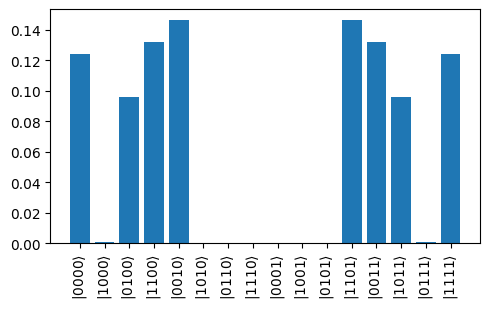

In [7]:
xlabels = []
for bstr in digits.(0:2^N-1, base=2, pad=N)
    push!(xlabels, "\$|" * prod([string(b) for b in bstr]) * "\\rangle\$")
end

figure(figsize=(5, 3.2))
ax = subplot(111)
bar(0:2^N-1, probs)
ax.set_xticks(0:2^N-1)
ax.set_xticklabels(xlabels, rotation=90)
minorticks_off()
tight_layout()

## Mean-Field Approximation

In [8]:
# schedule
p = 1000
τ = 0.5
γ = τ .* ((1:p) .- 1/2) ./ p |> collect
β = τ .* (1 .- (1:p) ./ p) |> collect
β[p] = τ / (4 * p)

times = range(0, 1, p+1);

In [9]:
mf_problem = Problem(p, J)

Problem
  num_qubits: Int64 3
  num_layers: Int64 1000
  local_fields: Array{Real}((3,)) Real[0.13375702345533, 0.0036930338557504432, 0.5303622417454488]
  couplings: Array{Real}((3, 3)) Real[0.0 0.5428970107716381 -1.3951405027746535; 0.5428970107716381 0.0 -0.9460077791129564; -1.3951405027746535 -0.9460077791129564 0.0]
  edges: Array{CartesianIndex{2}}((6,))
  driver: YaoBlocks.ConstGate.XGate X


In [10]:
# initial spins
S = [[[1., 0., 0.] for _ in 1:N-1] for _ in 1:p+1]

# evolution with history
S = evolve!(S, mf_problem.local_fields, mf_problem.couplings, β, γ);

In [11]:
# helper function to reformat the data
get_spin_data = n -> mapreduce(permutedims, vcat, [S[k][n] for k in 1:p+1]) |> transpose;

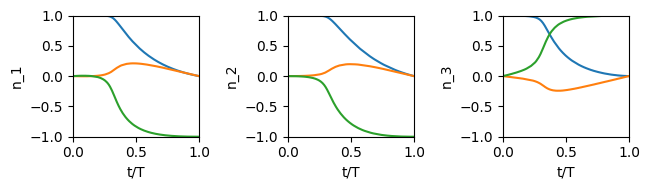

In [12]:
# plot x, y, and z of all spins 
figure(figsize=((N - 1) * 2.2, 2))

for n in 1:N - 1
    subplot(1, N - 1, n)
    plot(times, get_spin_data(n)[1, 1:end])
    plot(times, get_spin_data(n)[2, 1:end])
    plot(times, get_spin_data(n)[3, 1:end])
    xlim(0, 1)
    ylim(-1, 1)
    xlabel("t/T")
    ylabel("n_" * string(n))
end
tight_layout()

In [13]:
expectation(S[end], mf_problem.local_fields, mf_problem.couplings)

3.2769571556238626

## Annealing

In [31]:
T_anneal = 8.
p = 256
linear_schedule(t) = t / T_anneal
annealing_problem = QAOA.Problem(p, zeros(N), J);

In [32]:
probs = anneal(annealing_problem, linear_schedule, T_anneal)

16-element Vector{Float64}:
 9.999621274251871e-8
 1.7158575040108367e-6
 7.205803481684782e-7
 0.49829228900746886
 2.6823664621122006e-5
 2.7150936280911927e-7
 2.9323133320614927e-8
 0.0016780500613556078
 0.0016780500613556078
 2.9323133320614927e-8
 2.7150936280911927e-7
 2.6823664621122006e-5
 0.49829228900746886
 7.205803481684782e-7
 1.7158575040108367e-6
 9.999621274251871e-8

In [35]:
probs[4] == probs[end - 3]

true

true

0.49829228900746886